In [1]:
#import the required libraries
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.losses import categorical_crossentropy

2024-06-17 05:31:41.207808: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-17 05:31:41.207908: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-17 05:31:41.319298: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
len(gpus)

2

In [4]:
# Defining the path for train and test images
img_train = pathlib.Path("/kaggle/input/melanoma-skin-cancer-detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
img_test = pathlib.Path("/kaggle/input/melanoma-skin-cancer-detection/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [5]:
image_count_train = len(list(img_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(img_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


## **Load using keras.preprocessing**
Let's load these images off disk using the helpful image_dataset_from_directory utility.

### **Create a dataset**
Define some parameters for the loader:

In [6]:
#Visualize one instance of all the class present in the dataset.
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(img_train,batch_size=32,image_size=(180,180),label_mode='categorical',seed=123)

Found 2239 files belonging to 9 classes.


In [7]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(img_test,batch_size=32,image_size=(180,180),label_mode='categorical',seed=123)

Found 118 files belonging to 9 classes.


In [8]:
class_names = train_dataset.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [9]:
img_count=[len(os.listdir(str(img_train)+"/"+i)) for i in class_names]
print(list(zip(class_names,img_count)))

[('actinic keratosis', 114), ('basal cell carcinoma', 376), ('dermatofibroma', 95), ('melanoma', 438), ('nevus', 357), ('pigmented benign keratosis', 462), ('seborrheic keratosis', 77), ('squamous cell carcinoma', 181), ('vascular lesion', 139)]


In [10]:
img_class_count=pd.DataFrame(list(zip(class_names,img_count)),columns=['Class','Count'])
img_class_count

,Class,Count
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


In [11]:
pathlist=[str(img_train)+'/'+i for i in class_names]
print(os.listdir(pathlist[0]))
print(pathlist)

['ISIC_0027580.jpg', 'ISIC_0028063.jpg', 'ISIC_0027536.jpg', 'ISIC_0031108.jpg', 'ISIC_0026149.jpg', 'ISIC_0030825.jpg', 'ISIC_0027172.jpg', 'ISIC_0030036.jpg', 'ISIC_0026984.jpg', 'ISIC_0027829.jpg', 'ISIC_0030586.jpg', 'ISIC_0029025.jpg', 'ISIC_0031381.jpg', 'ISIC_0028558.jpg', 'ISIC_0026729.jpg', 'ISIC_0031993.jpg', 'ISIC_0026468.jpg', 'ISIC_0030491.jpg', 'ISIC_0033151.jpg', 'ISIC_0028393.jpg', 'ISIC_0030242.jpg', 'ISIC_0031040.jpg', 'ISIC_0026857.jpg', 'ISIC_0028190.jpg', 'ISIC_0030877.jpg', 'ISIC_0026905.jpg', 'ISIC_0029915.jpg', 'ISIC_0026702.jpg', 'ISIC_0031430.jpg', 'ISIC_0029827.jpg', 'ISIC_0033811.jpg', 'ISIC_0029141.jpg', 'ISIC_0027668.jpg', 'ISIC_0031292.jpg', 'ISIC_0028820.jpg', 'ISIC_0029930.jpg', 'ISIC_0030463.jpg', 'ISIC_0027650.jpg', 'ISIC_0025803.jpg', 'ISIC_0030655.jpg', 'ISIC_0027334.jpg', 'ISIC_0027447.jpg', 'ISIC_0032206.jpg', 'ISIC_0028990.jpg', 'ISIC_0030408.jpg', 'ISIC_0027896.jpg', 'ISIC_0027254.jpg', 'ISIC_0028941.jpg', 'ISIC_0028517.jpg', 'ISIC_0025992.jpg',

In [12]:
first_img_list=[i+'/'+os.listdir(i)[0] for i in pathlist]
first_img_list

['/kaggle/input/melanoma-skin-cancer-detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0027580.jpg',
 '/kaggle/input/melanoma-skin-cancer-detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/ISIC_0028059.jpg',
 '/kaggle/input/melanoma-skin-cancer-detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/ISIC_0027107.jpg',
 '/kaggle/input/melanoma-skin-cancer-detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0010080.jpg',
 '/kaggle/input/melanoma-skin-cancer-detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/ISIC_0000537.jpg',
 '/kaggle/input/melanoma-skin-cancer-detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/ISIC_0028100.jpg',
 '/kaggle/input/melanoma-skin-cancer-detection/Skin cancer ISIC The International Skin Imaging Colla

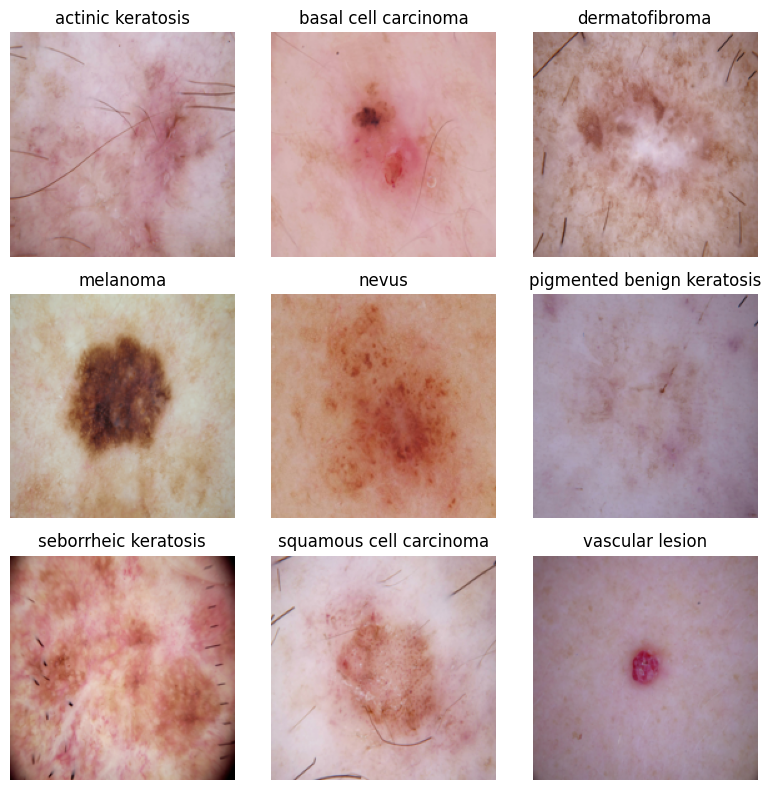

In [13]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i in range(len(first_img_list)):
  url=first_img_list[i]
  #print(url)
  image=PIL.Image.open(url)
  image=image.resize((180,180))
  ax=axes.flat[i]
  ax.imshow(image)
  ax.axis("off")
  ax.set_title(url.split('/')[-2])
plt.tight_layout()
plt.show()



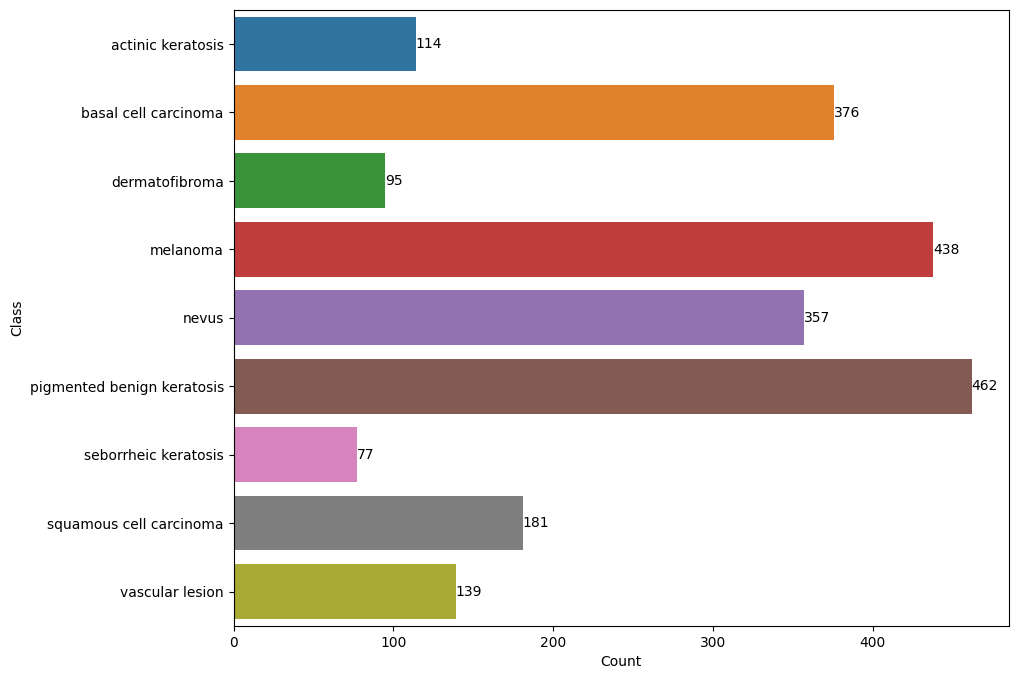

In [14]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
ax=sns.barplot(x="Count", y="Class", data=img_class_count,
            label="Class")
ax.bar_label(ax.containers[0])
plt.show()

We can clearly see the class imbalance in the above chart. Inorder to achieve class balancing,we need to use some augmentation techniques. 

## Model Building

In [15]:
# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(img_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [16]:
val_ds =tf.keras.preprocessing.image_dataset_from_directory(img_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Simple Model Without Dropout

In [18]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential()

model.add(layers.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
#model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
#model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
#Compile the Model
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [ ]:
# Train the model
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
(eval_loss, eval_accuracy) = model.evaluate(test_dataset, batch_size=32, \
                                            verbose=1)

In [ ]:
from glob import glob

Test_image_path = os.path.join(img_test, class_names[3], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-3],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)
img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class: "+ class_names[3] +'\n'+ "Predictive Class: "+pred_class +'\n'+ str(pred) )

In [ ]:
!pip install Augmentor

In [ ]:
import Augmentor

In [ ]:
train_dataset_path="/kaggle/input/melanoma-skin-cancer-detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
for i in class_names:
    p = Augmentor.Pipeline(train_dataset_path + i,output_directory='/kaggle/working/'+i+'/output/')
    p.rotate(probability=0.7, max_left_rotation=20, max_right_rotation=20)  # Random rotation
    p.sample(2000)

In [ ]:
# train dataset
aug_train_dataset = tf.keras.preprocessing.image_dataset_from_directory(output_path, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)
aug_val_dataset = tf.keras.preprocessing.image_dataset_from_directory(output_path, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="validation",
                                                               validation_split=0.2)

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
aug_train_dataset = aug_train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
aug_val_dataset = aug_val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(180, 180, 3)),  # Rescaling layer
  layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(128, activation="relu"),
  layers.Dropout(0.25),
  layers.Dense(len(class_names), activation="softmax")
])
model.summary()

In [ ]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [ ]:
# Train the model
epochs = 25
history = model.fit(aug_train_dataset, validation_data=aug_val_dataset, epochs=epochs,callbacks=[checkpoint,earlystop])

In [ ]:
epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
(eval_loss, eval_accuracy) = model.evaluate(test_dataset, batch_size=32, \
                                            verbose=1)

In [ ]:
from glob import glob

Test_image_path = os.path.join(img_test, class_names[3], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-3],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)
img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class: "+ class_names[3] +'\n'+ "Predictive Class: "+pred_class +'\n'+ str(pred) )

In [ ]:
out_img_count=[len(os.listdir(str(output_path)+"/"+i+'/output')) for i in class_names]
img_class_count=pd.DataFrame(list(zip(class_names,out_img_count)),columns=['Class','Count'])
img_class_count

Insights: 
- Class imbalance problems is rectified by using`Augmentor` library 
- By increasing the sample size, we can able to achieve the accuracy and solve the overfitting problem
- This can be further improved by using data Augmentation techniques to increase the accuracy. 
- Though we can evidence of overfitting we can clearly see the model can classify. 